## Imports

In [1]:
!pip install transformers datasets accelerate -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from pathlib import Path
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, f1_score, confusion_matrix

## Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_dir = Path('drive/MyDrive/Colab Notebooks/data/Quora_duplicates/processed_data')

train_df = pd.read_csv(data_dir / 'train_processed.csv.zip')
val_df = pd.read_csv(data_dir / 'val_processed.csv.zip')

train_df = train_df[['question1', 'question2', 'is_duplicate']]
val_df = val_df[['question1', 'question2', 'is_duplicate']]

print(f"Train shape:      {train_df.shape}")
print(f"Validation shape: {val_df.shape}")

Train shape:      (258743, 3)
Validation shape: (64686, 3)


In [5]:
train_df.head()

,question1,question2,is_duplicate
0,How are complementary colours coded for in neu...,My engineering degree contains my father's las...,0
1,When do you know you should take a break from ...,When you study and you've just finished 1 proj...,0
2,When and why did Apple move from the NYSE to t...,What are the different ways to do trading usin...,0
3,What is the best site to watch free online TV ...,What are the best TV shows online for free?,0
4,What gets you noticed enough by the company to...,Which African American NFL player holds the mo...,0


Since train datased is too big, for better performance, we can take part of it for training BERT model

In [6]:
train_df_small, _ = train_test_split(
    train_df,
    train_size=100000,
    stratify=train_df['is_duplicate'],
    random_state=42
)

In [7]:
print("Train class distribution:")
print(train_df_small['is_duplicate'].value_counts(normalize=True))
print("\nVal class distribution:")
print(val_df['is_duplicate'].value_counts(normalize=True))

Train class distribution:
is_duplicate
0    0.6308
1    0.3692
Name: proportion, dtype: float64

Val class distribution:
is_duplicate
0    0.630801
1    0.369199
Name: proportion, dtype: float64


## Train and Evaluate the Model

In [8]:
train_ds = Dataset.from_pandas(train_df_small.copy())
val_ds   = Dataset.from_pandas(val_df.copy())

ds = DatasetDict({"train": train_ds, "validation": val_ds})

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(batch):
    return tokenizer(
        batch["question1"],
        batch["question2"],
        truncation=True,
        padding=False,
        max_length=128
    )

tokenized_ds = ds.map(preprocess, batched=True)
tokenized_ds = tokenized_ds.remove_columns(["question1", "question2"])
tokenized_ds = tokenized_ds.rename_column("is_duplicate", "labels")
tokenized_ds.set_format("torch")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    probs = softmax(logits, axis=1)

    y_true = labels
    y_pred = probs.argmax(axis=1)

    return {
        "log_loss": float(log_loss(y_true, probs)),
        "f1": float(f1_score(y_true, y_pred))
    }

training_args = TrainingArguments(
    output_dir="./bert-quora",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="log_loss",
    greater_is_better=False,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    report_to="none",
    fp16=True,
    logging_steps=1000,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/64686 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3125476138.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [9]:
trainer.train()

Epoch,Training Loss,Validation Loss,Log Loss,F1,Runtime,Samples Per Second,Steps Per Second
1,0.346500,0.316349,0.316349,0.815705,40.736400,1587.917000,99.248000
2,0.261600,0.310121,0.310121,0.828807,40.781000,1586.179000,99.139000
3,0.181100,0.369669,0.369671,0.832473,40.471700,1598.301000,99.897000


TrainOutput(global_step=18750, training_loss=0.28738480631510416, metrics={'train_runtime': 629.9858, 'train_samples_per_second': 476.201, 'train_steps_per_second': 29.763, 'total_flos': 4614634299580416.0, 'train_loss': 0.28738480631510416, 'epoch': 3.0})

In [10]:
metrics = trainer.evaluate()

In [11]:
display(metrics)

{'eval_loss': 0.31012076139450073,
 'eval_log_loss': 0.3101209326973658,
 'eval_f1': 0.8288067357407067,
 'eval_runtime': 40.4877,
 'eval_samples_per_second': 1597.669,
 'eval_steps_per_second': 99.857,
 'epoch': 3.0}

In [12]:
train_metrics = trainer.evaluate(eval_dataset=tokenized_ds["train"])

In [13]:
display(train_metrics)

{'eval_loss': 0.15849080681800842,
 'eval_log_loss': 0.15849046828326213,
 'eval_f1': 0.9209812867817232,
 'eval_runtime': 68.2708,
 'eval_samples_per_second': 1464.756,
 'eval_steps_per_second': 91.547,
 'epoch': 3.0}

## Compare to Other Models

In [14]:
result_dir = Path('/content/drive/MyDrive/Colab Notebooks/data/Quora_duplicates')
results = joblib.load(result_dir / 'model_results.joblib')

In [15]:
results.append({
    "Model": "DistilBERT",
    "Log Loss (Train)": train_metrics["eval_log_loss"],
    "Log Loss (Val)": metrics["eval_log_loss"],
    "F1 Score (Train)": train_metrics["eval_f1"],
    "F1 Score (Val)": metrics["eval_f1"]
})

In [16]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Log Loss (Val)')

print("MODEL COMPARISON")
print("="*95)
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['Model']
best_logloss = results_df.iloc[0]['Log Loss (Val)']

print("="*95)
print(f"Best Model: {best_model_name}")
print(f"Best Log Loss: {best_logloss:.4f}")

MODEL COMPARISON
                     Model  Log Loss (Train)  Log Loss (Val)  F1 Score (Train)  F1 Score (Val)
                DistilBERT          0.158490        0.310121          0.920981        0.828807
      Ensemble (LR & LGBM)          0.449977        0.455301          0.732451        0.726993
           LightGBM TF-IDF          0.456264        0.460964          0.723241        0.719197
Logistic Regression TF-IDF          0.468778        0.476519          0.720060        0.711487
            XGBoost TF-IDF          0.479419        0.484274          0.707529        0.704374
                  LightGBM          0.529574        0.534111          0.666016        0.662117
             Random Forest          0.464022        0.535383          0.715439        0.659619
                   XGBoost          0.530302        0.535423          0.665930        0.661931
      Random Forest TF-IDF          0.550548        0.555328          0.675340        0.668246
       Logistic Regression       

`DistilBERT` model showed the best result.

## Save Model

In [17]:
save_dir = Path('/content/drive/MyDrive/Colab Notebooks/data/Quora_duplicates/model')
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('/content/drive/MyDrive/Colab Notebooks/data/Quora_duplicates/model/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/data/Quora_duplicates/model/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/data/Quora_duplicates/model/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/data/Quora_duplicates/model/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/data/Quora_duplicates/model/tokenizer.json')

In [18]:
result_dir = Path('/content/drive/MyDrive/Colab Notebooks/data/Quora_duplicates')
joblib.dump(results, result_dir / 'model_results_final.joblib')

['/content/drive/MyDrive/Colab Notebooks/data/Quora_duplicates/model_results_final.joblib']

## Final Evaluation on Test Dataset

In [19]:
test_df = pd.read_csv(data_dir / 'test_processed.csv.zip')
test_df = test_df[['question1', 'question2', 'is_duplicate']]

In [20]:
test_df.head()

,question1,question2,is_duplicate
0,Why is beef banned in India and not pork as well?,Is beef banned in india?,0
1,At what valuation did Homejoy raise money in D...,Should a wealthy founder self-fund his second ...,0
2,How do we judge?,How do I judge my love?,0
3,Are Adderall and meth the same?,Are concerta and meth test the same?,0
4,If you had internet access to only one site fo...,Why is there .co.uk for British internet sites...,0


In [21]:
print(f"Test shape: {test_df.shape}")
print(f"Test label distribution:")
print(test_df['is_duplicate'].value_counts(normalize=True))

Test shape: (80858, 3)
Test label distribution:
is_duplicate
0    0.630797
1    0.369203
Name: proportion, dtype: float64


In [22]:
test_ds = Dataset.from_pandas(test_df.copy())

def preprocess(batch):
    return tokenizer(
        batch["question1"],
        batch["question2"],
        truncation=True,
        padding=False,
        max_length=128
    )

tokenized_test = test_ds.map(preprocess, batched=True)
tokenized_test = tokenized_test.remove_columns(["question1", "question2"])
tokenized_test = tokenized_test.rename_column("is_duplicate", "labels")
tokenized_test.set_format("torch")

print("\nRunning evaluation on test set...")
predictions = trainer.predict(tokenized_test)

logits = predictions.predictions
labels = predictions.label_ids
probs = softmax(logits, axis=1)
y_pred = probs.argmax(axis=1)

print("\n" + "="*60)
print("BERT MODEL - TEST SET EVALUATION RESULTS")
print("="*60)
print(f"Test samples: {len(labels)}")

print("\nMetrics:")
print(f"  Log Loss:  {log_loss(labels, probs):.4f}")
print(f"  F1 Score:  {f1_score(labels, y_pred):.4f}")

print("\nPrediction Distribution:")
print(f"  Predicted Not Duplicate: {(y_pred == 0).sum():6d} ({(y_pred == 0).mean()*100:.1f}%)")
print(f"  Predicted Duplicate:     {(y_pred == 1).sum():6d} ({(y_pred == 1).mean()*100:.1f}%)")

Map:   0%|          | 0/80858 [00:00<?, ? examples/s]


Running evaluation on test set...



BERT MODEL - TEST SET EVALUATION RESULTS
Test samples: 80858

Metrics:
  Log Loss:  0.3110
  F1 Score:  0.8300

Prediction Distribution:
  Predicted Not Duplicate:  49396 (61.1%)
  Predicted Duplicate:      31462 (38.9%)


We can see good results on test dataset.

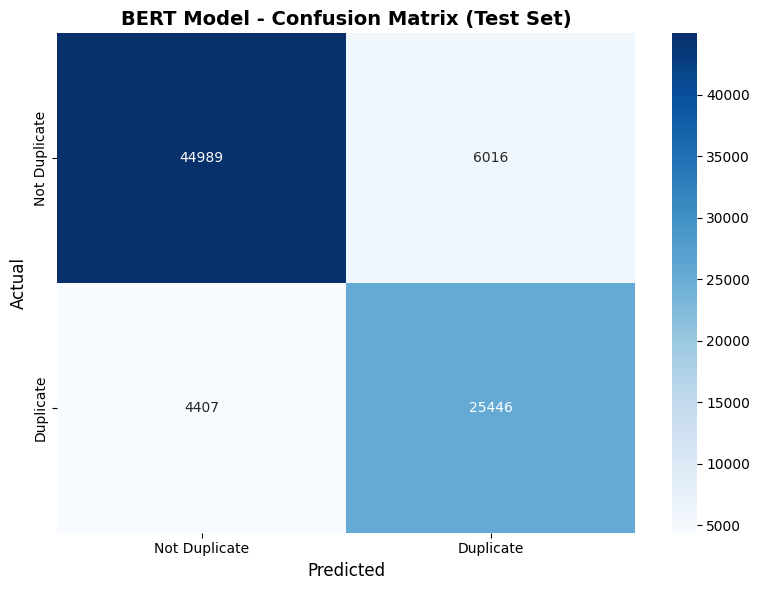

In [23]:
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Not Duplicate', 'Duplicate'],
            yticklabels=['Not Duplicate', 'Duplicate'])
plt.title('BERT Model - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

`DistilBERT` behaves like a well-calibrated, high-precision, high-recall semantic model:

- High TN → strong ability to reject unrelated pairs
- High TP → excellent paraphrase detection
- Low FN → rarely misses real duplicates
- Moderate FP → acceptable and much lower than classical ML models

The `DistilBERT` model achieved the best performance across all evaluated approaches. This demonstrates BERT’s strong semantic understanding, enabling it to detect paraphrased duplicates that traditional models often misclassify. Overall, BERT achieves the highest F1 score and lowest log loss, making it the most effective model for duplicate question detection.

In [24]:
predictions_df = test_df.copy()
predictions_df['predicted_duplicate'] = y_pred
predictions_df['probability_duplicate'] = probs[:, 1]
predictions_df['probability_not_duplicate'] = probs[:, 0]
predictions_df['correct'] = (predictions_df['is_duplicate'] == y_pred)

In [27]:
predictions_df.head(10)

,question1,question2,is_duplicate,predicted_duplicate,probability_duplicate,probability_not_duplicate,correct
0,Why is beef banned in India and not pork as well?,Is beef banned in india?,0,1,0.538100,0.461900,False
1,At what valuation did Homejoy raise money in D...,Should a wealthy founder self-fund his second ...,0,0,0.002862,0.997138,True
2,How do we judge?,How do I judge my love?,0,0,0.037257,0.962743,True
3,Are Adderall and meth the same?,Are concerta and meth test the same?,0,0,0.222869,0.777131,True
4,If you had internet access to only one site fo...,Why is there .co.uk for British internet sites...,0,0,0.002779,0.997221,True
5,What is the best ringtone song ever?,What are the most soothing songs that you have...,0,0,0.007563,0.992437,True
6,How can I use call forwarding with T-Mobile?,How do you use Call Forwarding with AT&T?,0,0,0.007417,0.992583,True
7,How do I remember study points?,How can I remember studying points?,1,1,0.978570,0.021430,True
8,How many hours have you spend on Quora?,How many hours a day do you spend on Quora?,1,1,0.955110,0.044890,True
9,Short story on pride and ego?,How would I know if lets say New York was nuke...,0,0,0.000330,0.999670,True


In [26]:
print("Sample Predictions (first 10 errors):")
errors_df = predictions_df[predictions_df['correct'] == False]
errors_df.head(10)

Sample Predictions (first 10 errors):


,question1,question2,is_duplicate,predicted_duplicate,probability_duplicate,probability_not_duplicate,correct
0,Why is beef banned in India and not pork as well?,Is beef banned in india?,0,1,0.538100,0.461900,False
15,What is blacking out?,What is Black out?,0,1,0.964221,0.035779,False
25,How do I raise funds for early stage startup?,What are the best ways to raise funds for a st...,0,1,0.712732,0.287268,False
48,What's it like dating someone with a high IQ?,What is it like to date someone with a 150 IQ?,1,0,0.027143,0.972857,False
51,When is it too late to study medicine and beco...,"I'm 37 years old, am I too old to go to school...",1,0,0.245944,0.754056,False
76,Is it good to be sober?,What is it like to be sober?,0,1,0.573716,0.426284,False
89,What is the spookiest experience you've ever had?,What's the most haunted experience you have ev...,1,0,0.462959,0.537041,False
101,"Can India, Pakistan and Bangladesh unite?","Will India, Pakistan and Afghanistan ever unit...",1,0,0.015058,0.984942,False
110,What percentage of people with Hong Kong perma...,What percentage of Hong Kong Permanent Residen...,1,0,0.153169,0.846831,False
116,How many rovers are currently on the moon?,How many moon rovers were made?,0,1,0.895933,0.104067,False


The error analysis reveals several systematic patterns in BERT’s mistakes.

First, the model tends to overpredict duplicates in cases where two questions are semantically related but not labeled as duplicates (e.g., “How do I raise funds for a startup?” vs “What are the best ways to raise funds for a startup?”).

Second, BERT occasionally fails to classify paraphrases when they involve subtle numerical or domain-specific equivalences (e.g., “high IQ” vs “150 IQ”). These mistakes reflect known limitations of transformer models in numerical reasoning.

Finally, some errors arise from conceptual similarities rather than exact question intent, such as medical or personal advice contexts. Overall, the majority of BERT’s “errors” are understandable and often involve ambiguous or inconsistently labeled question pairs rather than clear model failures.